In [2]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOLDVIR as HALOVI
from complementary_models import HALOLDVAER as HALOVAE
import scanpy as sc
import scvi
import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [3]:
### test whole data with RNA only 
adata_multi = sc.read_h5ad("PBMC/CD8_Tlymph.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)


In [4]:
adata_multi

AnnData object with n_obs × n_vars = 1934 × 144978
    obs: 'celltype', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'batch_id'
    var: 'gene_ids', 'feature_types', 'modality'

In [5]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :36601


In [4]:
model.train(max_epochs=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/10:  40%|████      | 4/10 [00:09<00:13,  2.31s/it, loss=1.58e+04, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
model = model.load("linearModel", adata_mvi)

INFO     File linearModel/model.pt already downloaded                                        
n_genes :14583


In [14]:
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(0)
model.train(max_epochs=100)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it, loss=2.97e+04, v_num=1]


In [11]:
model.module.set_train_params(expr_train=True, acc_train=False)
model.module.set_finetune_params(0)
model.train(max_epochs=100)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=20 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it, loss=5.78e+03, v_num=1]


In [13]:
model.module.set_train_params(expr_train=False, acc_train=True)
model.module.set_finetune_params(0)
model.train(max_epochs=50)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=50 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s, loss=1.37e+04, v_num=1]


In [16]:
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(2)
model.train(max_epochs=100)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 74/100:  73%|███████▎  | 73/100 [02:21<00:52,  1.96s/it, loss=8.99e+04, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [17]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

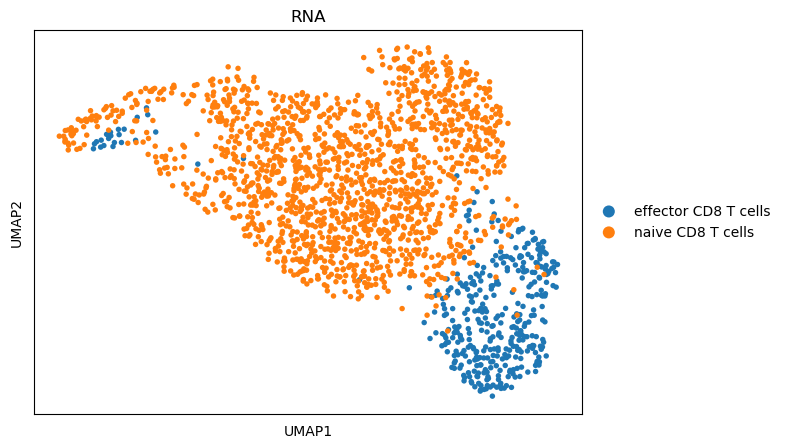

In [18]:
import matplotlib.pyplot as plt
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'RNA')
plt.show()

In [14]:
from complementary_models import torch_infer_nonsta_dir


latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
score3 - score4

tensor(-0.0002, device='cuda:0', dtype=torch.float64)

In [19]:
loadmatrix = model.module.get_loadings()

In [20]:
loadmatrix.shape

(36601, 10)

In [21]:
loadmatrix_dep = np.abs(np.sum(np.abs(loadmatrix[:, :5])/5, axis=1))
loadmatrix_indep = np.abs(np.sum(np.abs(loadmatrix[:, 5:])/5, axis=1))
loadatrix = np.concatenate([[np.abs(loadmatrix_dep)], [np.abs(loadmatrix_indep)]], axis=0)

In [22]:
print(max(loadmatrix_dep), min(loadmatrix_dep))

0.5470393 0.010737576


In [53]:
dep_index1 =  np.where(loadmatrix_dep > 0.2)
dep_index2 =  np.where(loadmatrix_indep < 0.1)

In [54]:
## dependent genes
print (((set(dep_index1[0]) & set(dep_index2[0]))))

{24577, 32771, 24580, 24584, 32793, 32798, 16415, 38, 32809, 57, 58, 32835, 32838, 77, 16462, 16467, 32854, 24675, 24683, 8301, 8302, 8306, 116, 16515, 32900, 24710, 137, 145, 16537, 8346, 8354, 166, 32945, 32967, 32968, 16587, 32972, 32975, 209, 24785, 220, 32991, 16611, 24803, 24805, 233, 247, 24824, 8441, 249, 253, 266, 8461, 33047, 24856, 287, 33062, 33072, 8507, 33095, 33097, 334, 16729, 351, 24930, 356, 33139, 24949, 33141, 24956, 33150, 8580, 8586, 16779, 8599, 24993, 16833, 16841, 479, 484, 16881, 16889, 16890, 33280, 516, 519, 8712, 33308, 33314, 16943, 8756, 8758, 569, 571, 8769, 582, 16968, 33356, 589, 594, 16990, 33377, 610, 17014, 632, 17016, 33409, 8834, 8840, 8842, 657, 17047, 17055, 8871, 680, 33451, 33453, 8879, 33455, 690, 8882, 25271, 25275, 17096, 17108, 33494, 25306, 732, 17120, 25313, 741, 25317, 746, 33515, 33526, 17145, 25338, 17150, 780, 8974, 783, 787, 25369, 8989, 804, 33574, 33580, 824, 17211, 9026, 17218, 17219, 33606, 33612, 846, 851, 17242, 17243, 25436, 

In [51]:
dep_index1 =  np.where(loadmatrix_indep > 0.1)
dep_index2 =  np.where(loadmatrix_dep < 0.1)

In [52]:
## independent genes

print((set(dep_index1[0]) & set(dep_index2[0])))

{24582, 8200, 32779, 16396, 24589, 14, 16399, 8208, 32, 8227, 8228, 24612, 32807, 32808, 16428, 8237, 16429, 47, 8240, 16433, 32824, 32825, 8258, 32837, 74, 24654, 32848, 32849, 82, 16465, 8281, 16475, 24670, 32866, 8297, 16489, 112, 8308, 24692, 32886, 16503, 24694, 8318, 16518, 32912, 24723, 16533, 151, 24728, 8345, 24732, 8350, 16549, 24748, 8369, 32952, 32958, 24767, 32969, 32970, 205, 32973, 210, 211, 24787, 217, 16604, 224, 227, 24807, 241, 33009, 24821, 24823, 16634, 8443, 254, 8448, 260, 33034, 16656, 8473, 24858, 33063, 24878, 24889, 24898, 8515, 16708, 33094, 8519, 33098, 8530, 24919, 8538, 24925, 24926, 8546, 33126, 8557, 8572, 382, 387, 389, 8585, 8588, 24976, 401, 33170, 33173, 24984, 33178, 414, 25001, 8620, 432, 16818, 33211, 446, 33219, 16838, 8648, 33233, 16868, 16872, 8697, 16892, 8702, 518, 520, 16907, 16913, 16918, 33310, 544, 16928, 8739, 8749, 560, 16956, 8767, 576, 33349, 33350, 16971, 16977, 8786, 16983, 33371, 608, 25190, 33390, 33396, 17019, 637, 17029, 649, 1

In [15]:
x = np.array([[0, 10, 20], [20, 30, 40]])
print("Values bigger than 10 =", x[x>10])
print("Their indices are ", np.nonzero(x > 10))


Values bigger than 10 = [20 20 30 40]
Their indices are  (array([0, 1, 1, 1]), array([2, 0, 1, 2]))


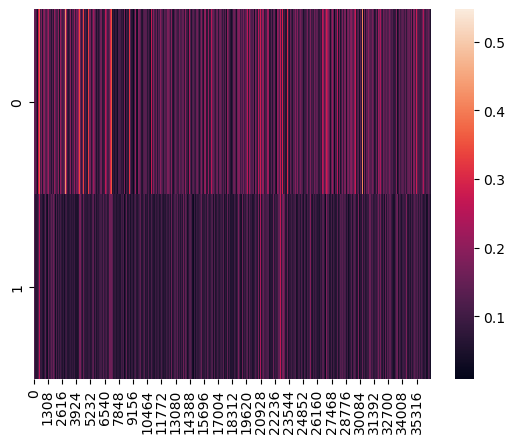

In [47]:
import seaborn as sns

sns.heatmap(loadatrix)
plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


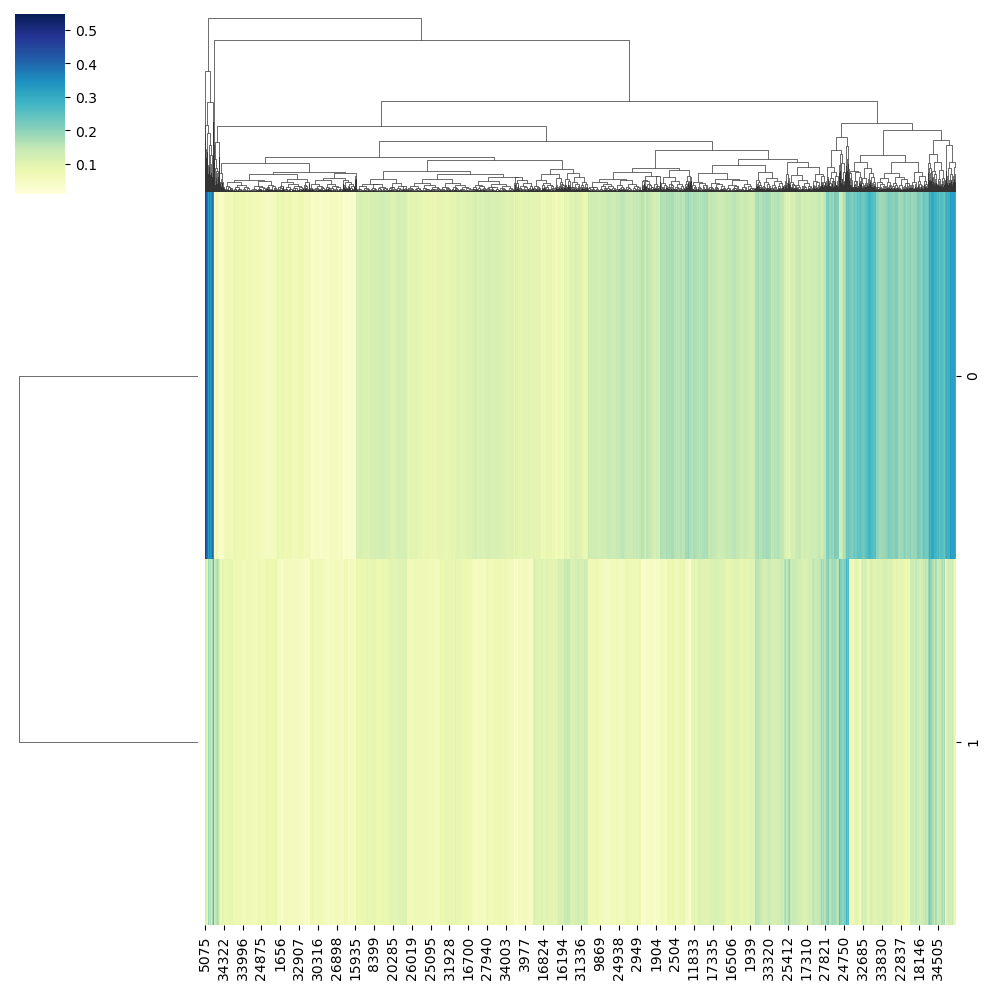

In [50]:
p = sns.color_palette('YlGnBu', as_cmap=True)

sns.clustermap(loadatrix, cmap= p)
plt.savefig("pbmc_loadmatrix.pdf")

In [49]:
plt.savefig("pbmc_loadmatrix.pdf")

<Figure size 640x480 with 0 Axes>

In [58]:
from complementary_models import MultiVI_Parallel

adata_multi = sc.read_h5ad("PBMC/CD8_Tlymph.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
MultiVI_Parallel.setup_anndata(adata_mvi, batch_key="modality")

model = MultiVI_Parallel(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

In [59]:
model.train(use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


Epoch 375/500:  75%|███████▌  | 375/500 [13:55<04:38,  2.23s/it, loss=1.04e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 21507.920. Signaling Trainer to stop.


In [60]:
z,z_atac,z_rna = model.get_latent_representation()

In [61]:
np.save("z_pbmc_multivi", z)

np.save("z_atac_pbmc_multivi", z_atac)


np.save("z_rna_pbmc_multivi", z_rna)

